/Users/seanchen/prj/scrapy_giant/crawler/spiders
(60, 200, 3)


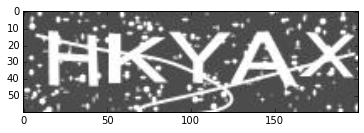

In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import cv2
import os
import cv
import numpy as np

cwd = os.getcwd()
print cwd

# raw img display
image = cv2.imread("./train/twse_test0.jpeg")
#print image
plt.imshow(image)
print image.shape

(60, 200)


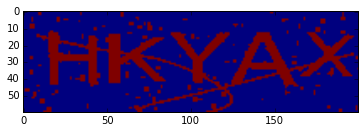

In [2]:
def normalize(img):
    img = cv2.cvtColor(img, cv2.CV_32F)
    # rgb 2 gray
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    gray = cv2.equalizeHist(gray)
    ret,th0 = cv2.threshold(gray, 200, 255, cv2.THRESH_BINARY)
    return th0

gray = normalize(image)
plt.imshow(gray)
print gray.shape

In [3]:
# find most closest 
def img_absdiff(imgA, imgB):
    xA, yA = imgA.shape
    xB, yB = imgB.shape
    
    # resize imgB to imgA if size not same
    if xB != xA or yB != yA: 
        imgB = cv2.resize(imgB, (x,y), interpolation=cv2.INTER_CUBIC)
    
    diff = np.diff(imgA.astype('float') - imgB.astype('float'))
    absdiff = np.sum(diff**2)
    return absdiff / (xA * yA)

print img_absdiff(gray, gray)

0.0


In [4]:
def resize(img, resize=1):
    # scalar must be int
    h,w = img.shape
    img = cv2.resize(img, (w*resize,h*resize), interpolation=cv2.INTER_CUBIC)
    return img

In [5]:
def inverse(img):
    pass 

(60, 200)


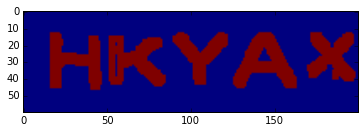

In [6]:
def feature_extract(img):
    # smooth background noise
    kernel = np.ones((4,4), np.uint8)
    erosion = cv2.erode(img, kernel, iterations=1)
    blurred = cv2.GaussianBlur(erosion, (5,5), 0)
    # enhance img edge 
    edged = cv2.Canny(blurred, 30, 150)
    dilation = cv2.dilate(edged, kernel, iterations=1)
    return dilation 

dilation = feature_extract(image)
print dilation.shape
plt.imshow(dilation)

In [7]:
def bitwise_and_noise_reduce(img):  
    kernel = np.ones((1,1), np.uint8)
    # threshold filter
    ret,th1 = cv2.threshold(img, 235, 255, cv2.THRESH_BINARY)
    # colsing/opening
    open = cv2.morphologyEx(th1, cv2.MORPH_OPEN, kernel, iterations=5)
    close = cv2.morphologyEx(open, cv2.MORPH_CLOSE, kernel, iterations=5)
    mask = cv2.bitwise_and(th1, th1, mask=close)
    return mask

In [8]:
def find_best_char_index(img):
    # feature select order by roll win area size    
    contours, hierarchy = cv2.findContours(img.copy(), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)    
    cnts = sorted([(c, cv2.boundingRect(c)[0]) for c in contours], key=lambda x:x[1])

    ary = []
    for (c, _) in cnts:
        x, y, w, h = cv2.boundingRect(c)
        if w>15 and h>15:
            ary.append((x, y, w, h))
    return ary

In [9]:
def iter_find_best_char_index(img, bund=1, limit=5):
    # feature select order by roll win area size
    h, w = img.shape
    area = lambda (x, y, w, h): (w*h, x, y, w, h)
    contours, hierarchy = cv2.findContours(img.copy(), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)    
    best = sorted([area(cv2.boundingRect(cnt)) for cnt in contours], reverse=True)
    # iter sub captcha
    x0 = lambda x: x-bund if x > bund else 0
    y0 = lambda y: y-bund if y > bund else 0
    x1 = lambda x: x+bund if w-bund > x else w
    y1 = lambda y: y+bund if h-bund > y else h
    for it in sorted(best[:limit], key=lambda x: x[1]):
        yield ((x0(it[1]),y0(it[2])), (x1(it[1]+it[3]),y1(it[2]+it[4])))


In [10]:
def clone_img_to_blank(img, outer=4):
    h, w = img.shape
    bkimg = np.zeros((h+outer,w+outer,3), np.uint8)
    bkimg = resize(normalize(bkimg), 1)
    return bkimg

In [11]:
def export_char(ary, img, outer=4):
    figs = []
    
    for id, (x,y,w,h) in enumerate(ary):
        roi = img[y-outer:y+h+outer, x-outer:x+w+outer]
        thresh = roi.copy()
        res = cv2.resize(thresh, (50, 50))
        # export chart as sample data
        cv2.imwrite("./train/twse_c_%0d.png" %(id), res)
        figs.append(res)
    return figs

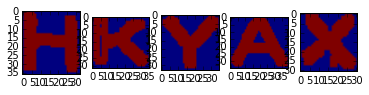

In [12]:
# try to clone feature to a new noe
fig = plt.figure()
i = 0
bkimg = clone_img_to_blank(dilation, 4)
nwimg = bitwise_and_noise_reduce(dilation)

for bund in iter_find_best_char_index(nwimg, 1, 5):
    x,y = zip(*bund)
    ff = nwimg[y[0]:y[1],x[0]:x[1]]
    bkimg[y[0]:y[1],x[0]:x[1]] = ff
    a = fig.add_subplot(1, 5, i+1)
    plt.imshow(ff)
    i+=1

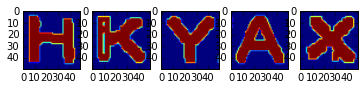

In [13]:
fig = plt.figure()

chars = find_best_char_index(nwimg)
figs = export_char(chars, nwimg)

#chars = find_best_char_index(dilation)
#figs = export_char(chars, dilation)

# plot each sample with chart edge extract 
for i, ff in enumerate(figs):
    a = fig.add_subplot(1,len(chars), i+1)
    plt.imshow(ff)

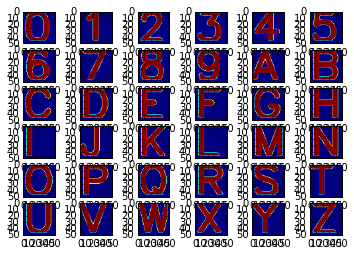

In [14]:
import string

fig = plt.figure()

def download_test_model():
    pass

def resize_train_model(txtimg):
    bkchar = clone_img_to_blank(txtimg)
    for bund in iter_find_best_char_index(txtimg, 1, 1):
        x,y = zip(*bund)
        bkchar[y[0]:y[1],x[0]:x[1]] = txtimg[y[0]:y[1],x[0]:x[1]]
        thresh = bkchar.copy()
        res = cv2.resize(thresh, (50, 50))
        return res

def export_train_model(c, txtimg):
    cv2.imwrite("./train/golden_c_%0s.png" %(c), txtimg)

def iter_train_model(h=50, w=50): 
    d = dict.fromkeys(string.ascii_uppercase + string.digits, 0)
    a = [i for i in d.keys()]
    a.sort()    
    
    font = cv2.FONT_HERSHEY_DUPLEX
    font = cv2.FONT_HERSHEY_SIMPLEX
    
    for i, c in enumerate(a): 
        txtimg = np.zeros((h,w,3), np.uint8)
        cv2.putText(txtimg, c, (1, min(h,w)-1), font, 2.2, (255,255,255), 8, 0)
        txtimg = normalize(txtimg)
        yield c, txtimg

i = 0
for c, txtimg in iter_train_model():
    txtimg = resize_train_model(txtimg)
    export_train_model(c, txtimg)
    b = fig.add_subplot(6,6,i+1)
    i+=1
    plt.imshow(txtimg)  

In [15]:
# collect each sample
pic_v = []
for i in range(5):
    img = cv2.imread("./train/twse_c_%0d.png" %(i))
    img = normalize(img)
    pic_v.append(img)
    
# collect golden model
golden_v = []
train_v = sorted(dict.fromkeys(string.ascii_uppercase + string.digits, 0).keys())
for c in train_v:
    img = cv2.imread("./train/golden_c_%0s.png" %(c))
    img = normalize(img)
    golden_v.append((c,img))
    
# find best match with golden
# it's very difficult to map test to golen, due to some noise values are not predictable
for test in pic_v:
    best_c, minclose = [], -1
    for c, golden in golden_v:
        minclose = img_absdiff(test, golden)
        best_c += [(c, minclose)]
        best_c = sorted(best_c, key=lambda x: x[1])[:5]
          
    print best_c

[('F', 2757.0599999999999), ('E', 2809.0799999999999), ('I', 2809.0799999999999), ('L', 2913.1199999999999), ('P', 3329.2800000000002)]
[('Z', 6814.6199999999999), ('7', 6918.6599999999999), ('S', 6918.6599999999999), ('F', 6970.6800000000003), ('I', 6970.6800000000003)]
[('1', 4811.8500000000004), ('T', 5123.9700000000003), ('E', 5280.0299999999997), ('F', 5280.0299999999997), ('I', 5280.0299999999997)]
[('3', 5488.1099999999997), ('F', 5488.1099999999997), ('I', 5488.1099999999997), ('E', 5540.1300000000001), ('L', 5540.1300000000001)]
[('T', 5254.0200000000004), ('Z', 5462.1000000000004), ('F', 5514.1199999999999), ('I', 5514.1199999999999), ('L', 5514.1199999999999)]


In [16]:
# use pytesser wrapper to call "tesseract-ocr" exe
# Optical Character Recognition(OCR)
# % tesseract imagename outputbase [-l lang] [-psm pagesegmode] [configfiles...]
# % tesseract train/twse_c_0.png txt -psm 10 | tail -n 2
# % vim txt.txt to get right ocr result

import subprocess
import pytesser

golden_txt = []
for c, pic in golden_v:
    txt = pytesser.iplimage_to_string(cv.fromarray(pic), 'eng', 7).strip()
    txt = txt.upper()
    golden_txt.append((c==txt, txt))
    
corr_rate = float(sum(map(lambda x: x[0], golden_txt))) / len(golden_v) if golden_v else 0.0
print "corr_rate %0.2f" %round(corr_rate, 2) 

test_txt = []
for pic in pic_v:
    txt = pytesser.iplimage_to_string(cv.fromarray(pic), 'eng', 10).strip()
    txt = txt.upper()
    test_txt.append(txt)
print test_txt    
    

corr_rate 0.92
['H', 'I', 'Y', 'A', 'X']
